

#Using Delta Anomaly Score for Anomaly Detection. 


Setting up the enviroment

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#Setting up the random state
rng = np.random.RandomState(42)

## Setting up user functions

In [0]:
def make_scatter(X, labels, legend=False):
  """Takes in a X with shape (n,2) and labels shape(n,1) and returns a
  scatter plot"""
  if len(labels.shape) == 1:
    labels = labels.reshape(-1,1)
  scatter = plt.scatter(X[:,0], X[:,1], c=labels[:,0])
  if legend:
    plt.legend(*scatter.legend_elements())
  return scatter

## Setting up toy data
Two 10-d gaussian clusters are being created as the in-distributional (ID) data, and the out-of-distribution (OOD) data is uniformly sampled from -10,10 in all 10 dimensions. 

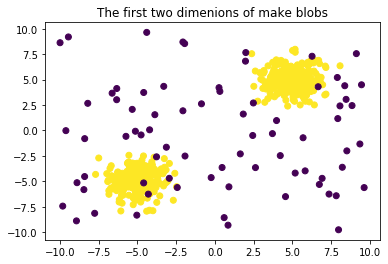

In [3]:
n_features = 10
n_id_samples = 500
n_ood_samples = int(.15 * n_id_samples)

X_in, y_in = datasets.make_blobs(n_samples=n_id_samples, n_features=10, 
                                 centers=((-5,-5,-5,-5,-5,-5,-5,-5,-5,-5),
                                          (5,5,5,5,5,5,5,5,5,5)), 
                                 random_state=rng)

X_ood = np.random.uniform(-10,10, size=(n_ood_samples, n_features))
y_in = np.full_like(y_in, 1)
y_ood = np.full(n_ood_samples, -1)
# Adding OOD data to ID data
X_all = np.concatenate((X_in, X_ood), axis=0)
y_all = np.concatenate((y_in, y_ood), axis=0).reshape(-1,1)
# plotting
plt.title('The first two dimenions of make blobs')
scatter = make_scatter(X_all, y_all)

## Training and Testing the IF model


In [0]:
# Creating train, test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=.8, random_state=rng)

In [0]:
#Training and fitting the IF model
IF = IsolationForest(n_jobs=-1, random_state=rng).fit(X_train)
#Gathering predicitons
y_pred_train = IF.predict(X_train)
y_pred_test = IF.predict(X_test)
y_pred_ood = IF.predict(X_ood)

In [0]:
# #Plotting predicitons
# X_scatter = np.concatenate((X_train, X_test, X_ood), axis=0)
# y_scatter = np.concatenate((y_pred_train, y_pred_test, y_pred_ood), axis=0)
# fig, ax = plt.subplots()
# scatter_results = ax.scatter(X_scatter[:,0], X_scatter[:,1], c=y_scatter)
# ax.legend(*scatter_results.legend_elements())

## Roc Calulations

In [7]:
roc_auc_result = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC score: {roc_auc_result}')

ROC AUC score: 1.0


## Plotting the raw IF Predicitons

The first two dimensions of the data:


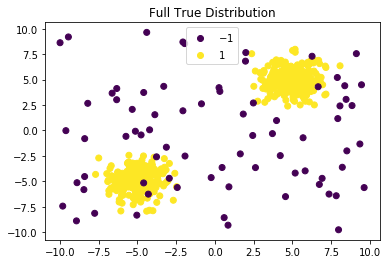

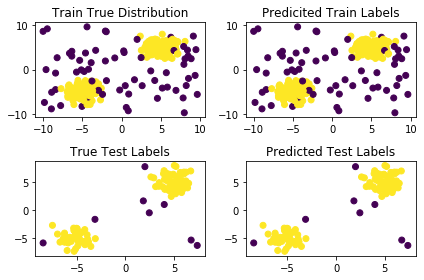

In [8]:
# Plotting predicitons
print('The first two dimensions of the data:')
plt.title('Full True Distribution')
scatter = make_scatter(X_all, y_all, legend=True)
plt.show()

plt.subplot(221)
plt.title('Train True Distribution')
scatter = make_scatter(X_train, y_train)
plt.subplot(222)
plt.title('Predicited Train Labels')
scatter = make_scatter(X_train, y_pred_train)
plt.subplot(223)
plt.title('True Test Labels')
scatter = make_scatter(X_test, y_test)
plt.subplot(224)
plt.title('Predicted Test Labels')
scatter = make_scatter(X_test, y_pred_test)
plt.tight_layout()
plt.show()

## Setting up delta anomaly score
This is a $\mathbb{R}^{nxp}$ matrix where $n$ is a the number of samples and $p$ is the number of features per samples. Each entry in the matrix is the difference in anomaly score for sample $n$ with all $p$ features and the sample $i$ with all $p$ features except for the $j^{th}$ feature. i.e. ($(m)_{i,j} = A(\mathbf{X}_i) - A(\mathbf{X}_{ij})$, where $\mathbf{X}_{ij}$ is the $i^{th}$ sample with the $j^{th}$ feature being treated as missing)